In [163]:
# LIBRERIAS
import matplotlib
from ipywidgets import interact,widgets
import numpy as np
import matplotlib.pylab as plt
import celluloid as cell  #animations
import pandas as pd
import os
from scipy.interpolate import CubicSpline
import math


#sns.set_theme()
#matplotlib.rc('xtick', labels
# ize=20) 
#matplotlib.rc('ytick', labelsize=20) 
font = {'weight' : 'bold',
        'size'   : 10}

matplotlib.rc('font', **font)

path=os.getcwd()



def fourierT(f):

    return (np.fft.fftshift(np.fft.fft(np.fft.fftshift(f))))


def fourierI(f):

    return (np.fft.fftshift(np.fft.ifft(np.fft.fftshift(f))))



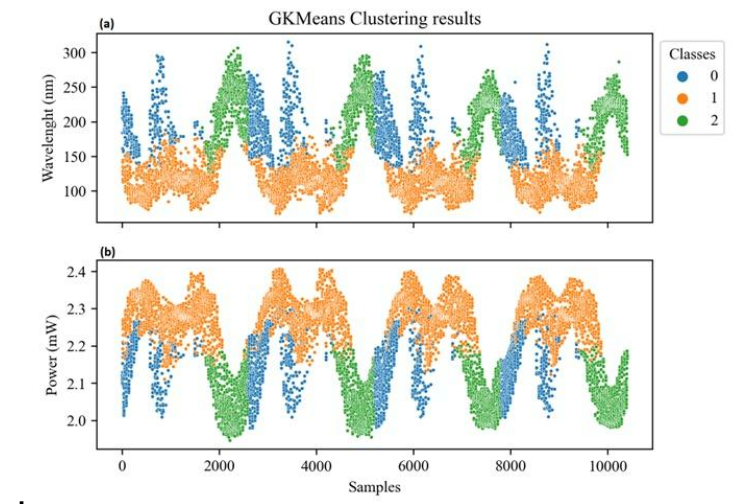

# Resultados obtenidos en el laboratorio.

In [160]:
def new_methodc(I1,I2,phi1,phi2,gamma,S,C,B,T,dt,h,cond=1):
    '''
    Este codigo calcula un paso espacial. Recibe un array
    con la intensidad y la fase. Modifica ese array para dar lugar al
    siguiente paso espacial.

    '''

    I1n_j = I1  # Recibe In_j
    phi1n_j = phi1  # Recibe phin_j
    I2n_j = I2  # Recibe In_j
    phi2n_j = phi2  # Recibe phin_j

    I1new = []
    phi1new = []
    I2new = []
    phi2new = []

    # Ciclo para calcular cada componente del array que contendra el siguiente
    # paso espacial
    for j in range(0,len(I1n_j)):

        I1tn_j = (I1n_j[j]+I1n_j[j-1])*0.5
        deltaI1n_j = I1n_j[j]-I1n_j[j-1]
        deltatheta1 = phi1n_j[j]-phi1n_j[j-1]
        deltatau1n_j = min([abs(deltatheta1),abs(deltatheta1+2*np.pi),abs(deltatheta1-2*np.pi)])

        I2tn_j = (I2n_j[j]+I2n_j[j-1])*0.5
        deltaI2n_j = I2n_j[j]-I2n_j[j-1]
        deltatheta2 = phi2n_j[j]-phi2n_j[j-1]
        deltatau2n_j = min([abs(deltatheta2),abs(deltatheta2+2*np.pi),abs(deltatheta2-2*np.pi)])

 
        if cond==1:
           


            if abs(deltatheta1) == deltatau1n_j:
                deltaphi1n_j = deltatheta1
            elif  abs(deltatheta1+2*np.pi) == deltatau1n_j:
                deltaphi1n_j = deltatheta1 + 2*np.pi
            else:
                deltaphi1n_j = deltatheta1 - 2*np.pi
                
            I1n1_j = I1n_j[j]-h/dt*gamma*S*((3*I1tn_j+B*I2tn_j)*deltaI1n_j
                                            +2*B*I1tn_j*deltaI2n_j)
            
            phi1tn1_j = phi1n_j[j]-h/dt*gamma*(T*(deltaI1n_j+B*deltaI2n_j)
                                    +S*(I1tn_j+B*I2tn_j)*deltaphi1n_j)
        
            phi1n1_j = phi1tn1_j + h*gamma*(I1n1_j+C*I2n_j[j])

            I1new.append(I1n1_j) # Intensidad en el siguiente paso espacial
            phi1new.append(phi1n1_j) #vfase en el siguiente paso espacial

        else:
            if abs(deltatheta2) == deltatau2n_j:
                deltaphi2n_j = deltatheta2
            elif  abs(deltatheta2+2*np.pi) == deltatau2n_j:
                deltaphi2n_j = deltatheta2 + 2*np.pi
            else:
                deltaphi2n_j = deltatheta2 - 2*np.pi
                

            I2n1_j = I2n_j[j]-h/dt*gamma*S*((3*I2tn_j+B*I1tn_j)*deltaI2n_j
                                            +2*B*I2tn_j*deltaI1n_j)
            phi2tn1_j = phi2n_j[j]-h/dt*gamma*(T*(deltaI2n_j+B*deltaI1n_j)
                                    +S*(I2tn_j+B*I1tn_j)*deltaphi2n_j
                                    )
            phi2n1_j = phi2tn1_j + h*gamma*(I2n1_j+C*I1n_j[j])

       
            I2new.append(I2n1_j) # Intensidad en el siguiente paso espacial
            phi2new.append(phi2n1_j) #vfase en el siguiente paso espacial

      
        # I2n_j = I2n1_j
        # phi2n_j = phi2n1_j
    if cond == 1:
        return np.sqrt(np.array(I1new))*np.exp(1j*np.array(phi1new))
    else:

        return np.sqrt(np.array(I2new))*np.exp(1j*np.array(phi2new))
    


def fourier_split_modc(A1,A2,V,delta,S,T,C,B,gammas,betas1,betas2,lenght,dt,steps):

    
    h = lenght/steps
  
    betas_freq1 = sum((1j)**(i+1)*betas1[i]*(1j*V)**(i+2)/math.factorial(i+2) for i in range(0,len(betas1)))
    betas_freq2 = sum((1j)**(i+1)*betas2[i]*(1j*V)**(i+2)/math.factorial(i+2) for i in range(0,len(betas2)))
    
    UD1 = np.exp(-h*0.5*betas_freq1,dtype=complex)
    UD2 = np.exp(-h*0.5*(betas_freq2+1j*delta*V),dtype=complex)



    for i in range(steps):
        
        stability1 = (h/dt*gammas[0]*S[0]*np.amax(3*np.abs(A1)**2+B[0]*np.abs(A2)**2))
        stability2 = (h/dt*gammas[1]*S[1]*np.amax(3*np.abs(A1)**2+B[1]*np.abs(A2)**2))

        if stability1 < 1 and stability2 < 2:
            print(True)

        A1a = fourierI(UD1*fourierT(A1))
        A2a = fourierI(UD2*fourierT(A2))
        I1 = np.abs(A1a)**2
        phi1 = np.angle(A1a)
        I2 = np.abs(A2a)**2
        phi2 = np.angle(A2a)
        

        A1as = new_methodc(I1,I2,phi1,phi2,gammas[0],S[0],C[0],B[0],T,dt,h/2)

        I1as = np.abs(A1as)**2
        phi1as = np.angle(A1as)

        A2aa = new_methodc(I1as,I2,phi1as,phi2,gammas[1],S[1],C[1],B[1],T,dt,h,cond=2)

        I2aa = np.abs(A2aa)**2
        phi2aa = np.angle(A2aa)
        
        A1aa = new_methodc(I1as,I2aa,phi1as,phi2aa,gammas[0],S[0],C[0],B[0],T,dt,h/2)
        
        A1 = fourierI(UD1*fourierT(A1aa))
        A2 = fourierI(UD2*fourierT(A2aa))

    return A1,A2


# Simulación laboratorio.

In [198]:
frep=37.5*1e6  # Tasa de repetición.
tau1=300e-15 ; tau2=200e-15 # Rango ancho temporal pulso.
WaveLength=1550e-9      #reference wavelength [m]
c = 299792458
w0 = (2*np.pi*c)/WaveLength  #reference frequency [Hz]
length = 2.0             #ibre length [m]
D=-1.0*1e-12*1e9*1e-3 #Dispersion
dD=0.006*1e-12*1e9**2*1e-3  #Dispersion slope
#betas = [beta2, beta3, ...] in units [s^2/m, s^3/m ...]
beta2=-WaveLength**2/(2*np.pi*c)*D
P0=130e-3 # Potencia media.
gamma=10.8*1e-3 # Coeficiente de nolinealidad fibra
Ppeak=P0/(frep*tau1)
Ld=tau1**2/beta2
Lnl=1/(Ppeak*gamma)
P0=130e-3 # Potencia media.
gamma=10.8*1e-3
Ppeak=P0/(frep*tau2)
Ld1=tau2**2/beta2
Ppeak2=P0/(frep*tau2)
Lnl1=1/(Ppeak2*gamma)

In [199]:
print('Ld, con 300 fs:',Ld)
print('Lnl, con 300 fs:',Lnl)
print('Ld, con 200 fs:',Ld1)
print('Lnl, con 200 fs:',Lnl1)

Ld, con 300 fs: 70.56343020095599
Lnl, con 300 fs: 0.008012820512820512
Ld, con 200 fs: 31.361524533758224
Lnl, con 200 fs: 0.005341880341880342


C:\Users\esteb\AppData\Local\Temp\ipykernel_14728\4010359025.py:5: RuntimeWarning: overflow encountered in cosh
  A = np.sqrt(Ppeak)*np.cosh(TimeGrid/(tau1/2.634))**(-1)  #np.sqrt(power)*1/np.cosh(TimeGrid/(t0/2.634)) # input field [W^(1/2)]


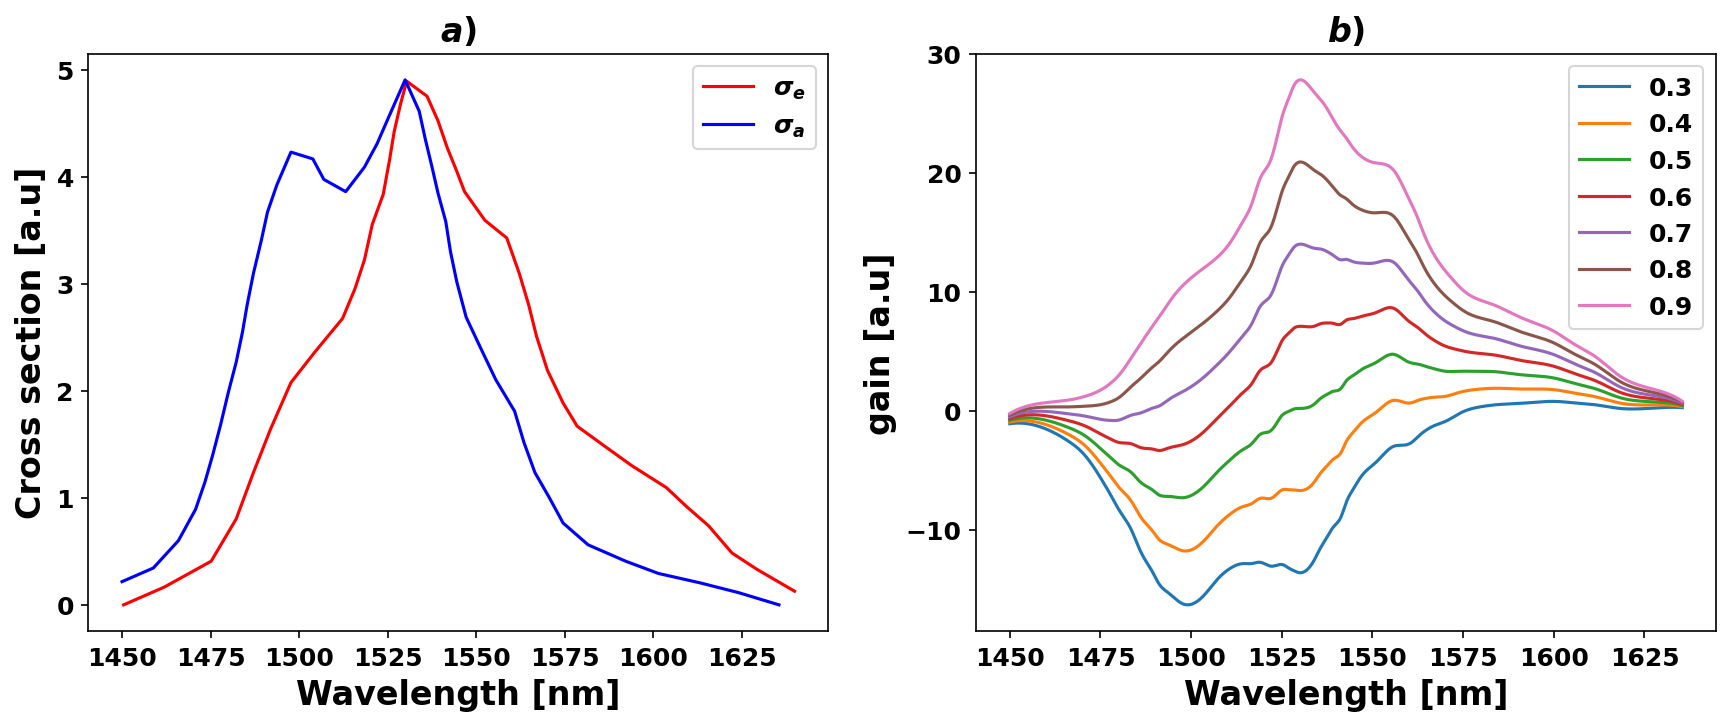

In [129]:
n = 2**12    # number of grid points
TimeWindow = 5*1e-12 # width of time window [s]     
dT = TimeWindow/n
TimeGrid =  np.arange(-TimeWindow,TimeWindow,dT) #  time grid
A = np.sqrt(Ppeak)*np.cosh(TimeGrid/(tau1/2.634))**(-1)  #np.sqrt(power)*1/np.cosh(TimeGrid/(t0/2.634)) # input field [W^(1/2)]
dw=np.pi/(n*dT)
V=np.array([j*dw for j in range(-int(n),int(n))])


# Load emission and absorcion cross-section
emis=np.loadtxt('Emision.txt',delimiter=';')
ab=np.loadtxt('Absorcion.txt',delimiter=';')

emis_y=emis[:,1]
emis_x=emis[:,0] #np.linspace(1400,1650,len(emis_y))
we=np.sort((2*np.pi*c/(emis_x*1e-9)*1e-12))
midwe=(max(we)+min(we))/2
we=we-midwe

abs_y=ab[:,1]
abs_x=ab[:,0] #np.linspace(1400,1650,len(emis_y))
wa=np.sort((2*np.pi*c/(abs_x*1e-9)*1e-12))
midwa=(max(wa)+min(wa))/2
wa=wa-midwa

cse1=CubicSpline(emis_x,emis_y)
emis_xdata=np.linspace(min(abs_x),max(emis_x),n*2)
Y_emis=cse1(emis_xdata)


# For simulation

cse=CubicSpline(we,emis_y)
csa=CubicSpline(wa,abs_y)

csa1=CubicSpline(abs_x,abs_y)
abs_xdata=np.linspace(min(abs_x),max(abs_x),n*2)
Y_abs=csa1(abs_xdata)


def gg1(G):

  return ((G)*cse1(emis_xdata)-(1-G)*csa1(abs_xdata))*7



f=plt.figure(figsize=(14,5),dpi=150)



plt.subplot(121)
plt.plot(emis_x,emis_y,'r',label='$\sigma_e$')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.plot(abs_x,abs_y,'b',label='$\sigma_a$')
plt.title('$a)$',fontsize=16,fontweight='bold')
plt.xlabel('Wavelength [nm]',fontsize=16,fontweight='bold')
plt.ylabel('Cross section [a.u]',fontsize=16,fontweight='bold')
plt.legend(fontsize=12)


D= np.arange(0.3,1,0.1)
plt.subplot(122)


for i in D:
    
    plt.plot(abs_xdata,gg1(i),label=str(round(i,3)))
    
    
plt.xlabel('Wavelength [nm]',fontsize=16,fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('gain [a.u]',fontsize=16,fontweight='bold')
plt.title('$b)$',fontsize=16,fontweight='bold')
plt.legend(fontsize=12)


# Simulación del EDFA

In [130]:
def erbium_fiber(u0,dt,dz2,nz2,PL,Tr,loss,D2,gamma2,G,GG):
    '''
    Propagates an initial field through erbium doper fiber

    Parameters 
    ----------
    u0: array_like
        initial field
    dt: float
        time resolution
    dz2: float
        spatial resolution
    nz2: float
        Number of points along progation distance
    PL: float
        Saturation power Erbium
    Tr: float
        Round trip
    loss: float
        linear fiber loss
    D2: float
        Fiber dispersion (beta2)
    gamma2: float
        nonlinear parameter
    G: float
        Related to pump power [0,1]
    GG: float
        'Amplitude of gain'
    '''

    nt = len(u0)
    luz = 299792458
    L = nt*dt
    t = np.linspace(-L/2,L/2,nt)
    dw = 2*np.pi/(nt*dt)
    V = np.array([j*dw for j in range(-int(nt/2), int(nt/2))]) # Frequency THz
    V = np.fft.fftshift(V)


    def gg(omega,G):
        
        return ((G)*cse(omega)-(1-G)*csa(omega))


    gain = gg(V,G)*GG
    
    gahno = gain*np.exp(-np.trapz(np.abs(u0)**2,t)/(PL*Tr))
    
    halfstep1=-loss+gahno-1j*D2/2*(1j*V)**2
   
    halfstep=np.exp(halfstep1*dz2/2)

    u1=u0

    # field propagation through fiber.
    for iz in range(1,nz2):

        ufft1= np.fft.fft(u1)
        uhalf1=np.fft.ifft(halfstep*ufft1)
        as1=(np.abs(u1)**2)
        uv1=uhalf1*np.exp((1j*gamma2*as1)*dz2) 
        uv1=np.fft.fft(uv1)
        ufft1=halfstep*uv1
        uv1=np.fft.ifft(ufft1)
        u1=uv1

    return u1

In [184]:
z2 = 0.3 # Erbium lenght
nz2 = 100 # Number of steps along fiber
dz2 = z2/nz2
n = 1.5 # Refractive index
Tr = ((((z2)*n)/luz))*1e12  # Round trip time
loss = 0 # Fiber loss
N = [0,1] #;N
GG = 4
PL = 0.64*1e-3#0.538*1e-3 # Saturatin power
D21 = -22.75  #; % parametro de dispersão (GVD)
wl = 1550
D2 = -(D21*wl**2/(2*np.pi*c))*1e-24  #% beta2 (ps^2/m)
gamma2 = 4.6*1e-3 # Nonlinear parameter

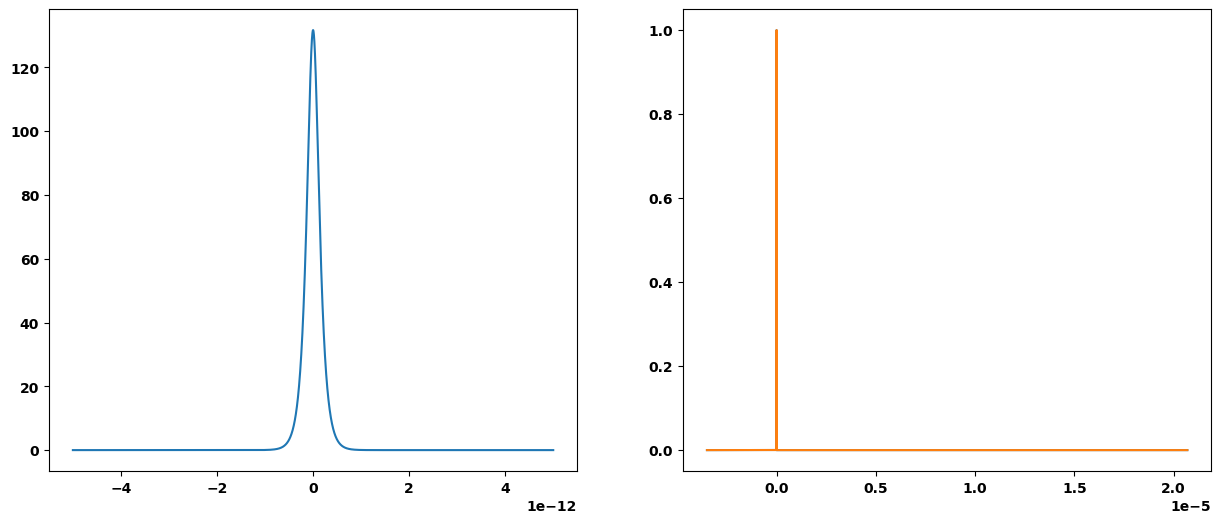

In [190]:
tau1 = 300e-15

f = plt.figure(figsize = (15,6))


plt.subplot(121)
A = np.sqrt(Ppeak)*np.cosh(TimeGrid/(tau1/2.634))**(-1)  #np.sqrt(power)*1/np.cosh(TimeGrid/(t0/2.634)) # input field [W^(1/2)]
plt.plot(TimeGrid,A)

plt.subplot(122)
y = erbium_fiber(A/max(A),dt,dz2,nz2,PL,Tr,loss,D2,gamma2,N[1],GG)
w=(V+w0)*1e12
WL=np.sort((2*np.pi*luz)/w)


yif = np.abs(fourierT(A))**2
yf = np.abs(fourierT(y))**2
plt.plot(WL*1e9,yf/max(yf))
plt.plot(WL*1e9,yif/max(yif))

In [65]:
def ruido(señal,desv): 
    '''
    Función para añadir ruido Gaussiano dada una desviación estandar

    Parametros
    ----------
    señal: Arreglo
      Arreglo con la señal a la que se le va añadir el ruido
    desv: float
      Desviación estandar
    '''
    señal_ruido=[np.random.normal(señal[i], abs(señal[i]*desv)) for i in range(0,len(señal))]
    return np.array(señal_ruido)

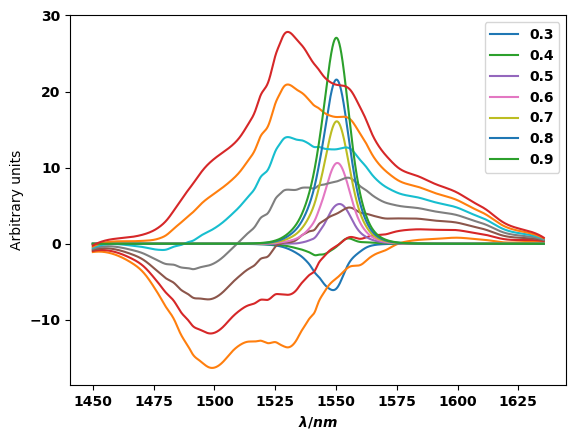

In [76]:
WL_central=1550
WL_in=abs_xdata
a=1
c=0.3
b=5
l=1
p=5
pulse=a*np.cosh((WL_in-WL_central)/b)**-1+c*np.cosh((WL_in-(WL_central+l))/p)**-1
y = ruido(pulse,0)
#plt.plot(dfA['Stop'][:],dfA['1749.9'][:]/max(dfA['1749.9'][:]),'k',label='Real+noise')
for i in D:
    
    plt.plot(WL_in,gg1(i)*y,label=str(round(i,3)))
    plt.plot(WL_in,gg1(i))

plt.xlabel('$\lambda /nm$')
plt.ylabel('Arbitrary units')
plt.legend()

# Simulación supercontinuo parametros actuales

# Sin EDFA 

In [200]:
frep=37.5*1e6  # Tasa de repetición.
tau1=300e-15 ; tau2=200e-15 # Rango ancho temporal pulso.
WaveLength=1550e-9      #reference wavelength [m]
c = 299792458
w0 = (2*np.pi*c)/WaveLength  #reference frequency [Hz]
length = 2.0             #ibre length [m]
D=-1e-12*1e9*1e-3 #Dispersion
dD=0.006*1e-12*1e9**2*1e-3  #Dispersion slope
beta2=-wl**2/(2*np.pi*c)*D
beta3=(wl**2/(2*np.pi*c))**2*(2*D/wl+dD)
betas=[beta2,beta3]
P0=130e-3 # Potencia media.
gamma=10.8*1e-3 # Coeficiente de nolinealidad fibra
Ppeak=P0/(frep*tau1)

Ld=tau1**2/beta2
Lnl=1/(Ppeak*gamma)
P0=130e-3 # Potencia media.
gamma=10.8*1e-3
Ppeak=P0/(frep*tau2)
Ld1=tau2**2/beta2
Ppeak2=P0/(frep*tau2)
Lnl1=1/(Ppeak2*gamma)

n = 2**12    # number of grid points
TimeWindow = 5*1e-12 # width of time window [s]     
dT = TimeWindow/n
TimeGrid =  np.arange(-TimeWindow,TimeWindow,dT) #  time grid
A = np.sqrt(Ppeak)*np.cosh(TimeGrid/(tau1/2.634))**(-1)  #np.sqrt(power)*1/np.cosh(TimeGrid/(t0/2.634)) # input field [W^(1/2)]
dw=np.pi/(n*dT)
V=np.array([j*dw for j in range(-int(n),int(n))])

In [ ]:
fourier_split_modc(A1,A2,V,delta,S,T,C,B,gammas,betas1,betas2,lenght,dt,steps)